There's an interesting tidbit that links the kernels to the attention mechanism. We will derive it from the Gaussian kernel. 

A Gaussian kernel is defined as follows: 
$$ K(x) = \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2}x^2} \tag{1}$$

We will drop the term $\frac{1}{\sqrt{2\pi}}$ as it represents only a scaling factor. 

Now, suppose we have three vectors, $\textbf{q} \in R^d$, $\textbf{v} \in R^d$, and $\textbf{k} \in R^d$.

We know from Nadaraya and Watson that the Nadaraya-Watson estimator rely on a similarity kernel $K$:  
$$f(\bf{q})=\sum_{i}\mathbf{v}_i\frac{K(\textbf{q} - \textbf{k}_i)}{\sum_jK(\textbf{q} - \textbf{k}_j)}$$

Now, this looks "oddly" similar to the attention mechanism proposed by [Bahdanau et al.](https://arxiv.org/pdf/1409.0473.pdf) in 2014. 

Well, it is! What's left is just to ensure we won't get negative weights. This can be easily achievied through exponentiation:  
$$f(\bf{q})=\sum_{i}\mathbf{v}_i\frac{\exp(K(\textbf{q} - \textbf{k}_i))}{\exp(\sum_jK(\textbf{q} - \textbf{k}_j))} \tag{2}$$

What's nice about this function is that we can replace $K(\textbf{q} - \textbf{k}_i)$ with _any_ function we want!

Now that we have our beloved attention mechanism, let's continue performing some simple manipulations. 

We start by removing the exponentation from Gaussian kernel, ending up with $-\frac{1}{2}x^2$. 

We'll substitute the $x$ with the Euclidean distance between the vectors $\mathbf{q}$ and $\mathbf{k}_i$, $|\mathbf{q} - \mathbf{k}_i|^2$.  

We can use the following identity based on the dot product to proceed further: 
$$|\mathbf{q} - \mathbf{k}_i|^2 = (\mathbf{q} - \mathbf{k}_i)^\top(\mathbf{q} - \mathbf{k}_i)$$

Expanding the right-hand side, we get:
$$(\mathbf{q} - \mathbf{k}_i)^\top(\mathbf{q} - \mathbf{k}_i) = \mathbf{q}^\top\mathbf{q} - \mathbf{q}^\top\mathbf{k}_i - \mathbf{k}_i^\top\mathbf{q} + \mathbf{k}_i^\top\mathbf{k}_i$$

Since $\mathbf{q}$ and $\mathbf{k}_i$ are vectors, we have $\mathbf{q}^\top\mathbf{q} = |\mathbf{q}|^2$ and $\mathbf{k}_i^\top\mathbf{k}_i = |\mathbf{k}_i|^2$. Substituting these expressions and rearranging terms, we get
$$|\mathbf{q} - \mathbf{k}_i|^2 = |\mathbf{q}|^2 - 2\mathbf{q}^\top\mathbf{k}_i + |\mathbf{k}_i|^2$$

Dividing both sides by 2, we get:

$$\alpha(\mathbf{q}, \mathbf{k}_i) = -\frac{1}{2} |\mathbf{q} - \mathbf{k}_i|^2 = \mathbf{q}^\top \mathbf{k}_i -\frac{1}{2} |\mathbf{k}_i|^2 -\frac{1}{2} |\mathbf{q}|^2$$ 

Some observations here. 

As we normalize our weights, the last term $\bf{q}$ will vanish, because the normalization is done over keys for each individual query, thus cancelling out. Next thing, the $\bf{k}$ term will tend to have a constant norm as we apply layer normalization, so it can be safely omitted as well. This leaves us with: 
$$\alpha(\mathbf{q}, \mathbf{k}_i) = \mathbf{q}^\top \mathbf{k}_i$$


The last thing we need to take into account is the fact that as the dimension of the $\bf{k}$ grows it increases the likelihood of getting large dots products that will dominate our training process. To alleviate this, we can divide by the square root of the dimensionality of this vector. Doing so we end up with: 
$$\alpha(\mathbf{q}, \mathbf{k}_i) = \mathbf{q}^\top \mathbf{k}_i \frac{1}{\sqrt(d)}$$

Using this function inside $(2)$ instead of $K(\textbf{q} - \textbf{k}_i)$ we end up with the famous attention mechanism that has been proposed by [Vaswani et al.](https://arxiv.org/abs/1706.03762) in the influential _Attention Is All You Need_ paper: 

$$\sum_{i}\mathbf{v}_i\frac{\exp(\mathbf{q}^\top \mathbf{k}_i \frac{1}{\sqrt(d)})}{\exp(\sum_j \mathbf{q}^\top \mathbf{k}_j \frac{1}{\sqrt(d)})} \tag{3}$$

or in matrix format 

$$\text{softmax}\bigg( \frac{\bf{Q} \bf{K}^\top}{\sqrt{d}}\bigg) \bf{V} \tag{4}$$

Let's have some fun with this ideas!

In [1]:
%load_ext autoreload
%autoreload 3

In [2]:
from beartype import beartype

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
plt.style.use('classic')

In [3]:
SEED    = 16244359319
N       = 150
MXRANGE = 5 

In [4]:
torch.manual_seed(SEED)

# define a random function to sample from
def f(x): return x**.5 * 2 * torch.sin(x**2) 

x          = x  = torch.arange(-3, 3, 0.1)
x_train, _ = torch.sort(torch.rand(1, N) * MXRANGE)
y_train    = f(x_train) + torch.randn(1, N)
x_val      = torch.arange(0, MXRANGE, 0.1).reshape(1, -1)
y_val      = f(x_val).reshape(1, -1)

Now we have to remap our data such that we're using the familiar notation q, k, v. 
As such, the values $\bf{v}$ can become the `y_train`, the keys $\bf{k}$ will map to `x_train`, and the queries $\bf{q}$ will be the values where we want to evaluate our function, namely `x_val`. 

In [5]:
q = x_val 
k = x_train
v = y_train

In [6]:
@beartype
class Kernels:
    def __init__(self, x: torch.Tensor):
        self.x = x

    def gaussian(self) -> torch.Tensor:
        return 1 / (2 * np.pi)**0.5 * torch.exp(-0.5 * (self.x)**2)

    def epanechnikov(self) -> torch.Tensor:
        return (0.75 * (1 - self.x**2)).clamp(min=0)

    def triangular(self) -> torch.Tensor:
        return (1 - self.x.abs()).clamp(min=0)

    def cosine(self) -> torch.Tensor:
        return (np.pi / 4 * torch.cos(np.pi / 2 * self.x)).clamp(min=0)

In [7]:
@beartype
def nadaraya_watson(q: torch.Tensor, k: torch.Tensor, v: torch.Tensor, kernel_type: str) -> tuple[torch.Tensor, torch.Tensor]:
    '''
    Nadaraya-Watson kernel regression through attention lens.
    '''
    assert q.dim() == k.dim() == v.dim() == 2, 'q, k, v must be 2D tensors'

    ker = Kernels(k - q.T) # queries against all keys using broadcasting
    if kernel_type   == 'gaussian': kernel = ker.gaussian()
    elif kernel_type == 'epanechnikov': kernel = ker.epanechnikov()
    elif kernel_type == 'triangular': kernel = ker.triangular()
    elif kernel_type == 'cosine': kernel = ker.cosine()
    else: raise NotImplementedError

    attention = kernel / kernel.sum(0, keepdim=True) # normalize

    return torch.einsum('ij, jk -> ik', attention, v.T), attention

In [8]:
def plot(q, k, v, test, kernels): 
    for kernel in kernels: 
        fig, axs = plt.subplots(1, 2, figsize=(16, 3))
        weights, attention_map = nadaraya_watson(q, k, v, kernel)
        axs[0].scatter(k, v, color='navy', marker='+', label='data')
        axs[0].plot(q.squeeze(), test.squeeze(), label='true', color='orange')
        axs[0].plot(q.squeeze(), weights.squeeze(), linestyle='--', label='fit', color='red')
        axs[0].legend(loc='lower left')
        axs[1].imshow(attention_map)
        fig.suptitle(f'Kernel: {kernel}')

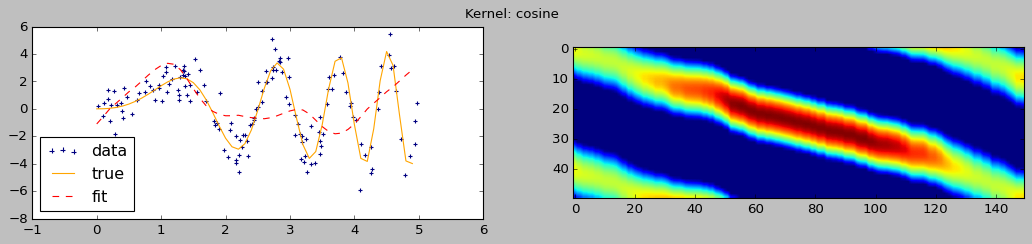

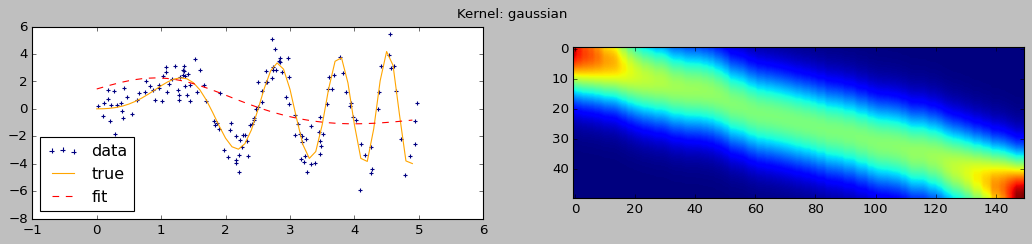

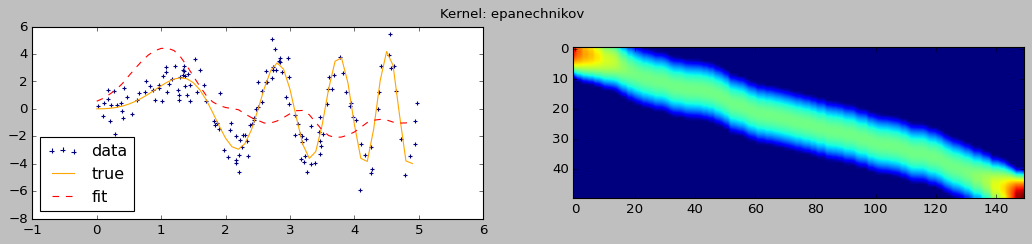

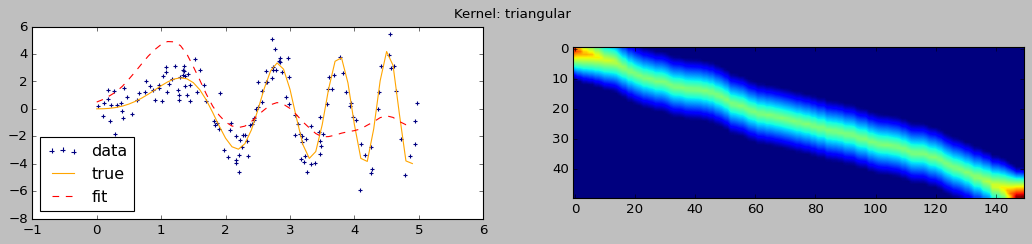

In [9]:
kernels = ['cosine', 'gaussian', 'epanechnikov', 'triangular']
plot(q, k, v, y_val, kernels)

The kernels did a decent job at fitting the true function. Can we do better? We sure can! Let's move on and actually implement the scaled dot product attention, and try to learn the queries, keys and values.  

In [10]:
@beartype
class Attention(nn.Module):
    def __init__(self, in_dim: int, qkv_dim: int, out_dim: int):
        super().__init__()
        self.q   = nn.Linear(in_dim, qkv_dim,  bias=False)
        self.k   = nn.Linear(in_dim, qkv_dim,  bias=False)
        self.v   = nn.Linear(in_dim, qkv_dim,  bias=False)
        self.out = nn.Linear(qkv_dim, out_dim, bias=False)

    def __call__(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        q, k, v = self.q(x), self.k(x), self.v(x)
        q = q.view(-1, 1)
        k = k.view(-1, 1)
        v = v.view(-1, 1)
        attention = torch.einsum('ij, jk -> ik', q, k.T) / np.sqrt(k.shape[-1])
        attention = F.softmax(attention, dim=-1)
        out = self.out(torch.einsum('ij, jk -> ik', attention, v).view(1, -1))

        return out, attention

In [11]:
LR      = 1e-2
MXITERS = 100
IN_DIM  = x_val.shape[-1]
QKV_DIM = 20 # relatively small dimension, but we don't need that much
OUT_DIM = y_val.shape[-1]

In [12]:
att = Attention(IN_DIM, QKV_DIM, OUT_DIM) 
optim = torch.optim.SGD(att.parameters(), lr=LR)
for _ in range(MXITERS):
    optim.zero_grad()
    out, att_map = att(x_val) # we switched back to x_val instead of q
    loss = F.mse_loss(out, y_val) 
    loss.backward()
    optim.step()
    print(loss.item(), end='\r')

Let's plot the results. 

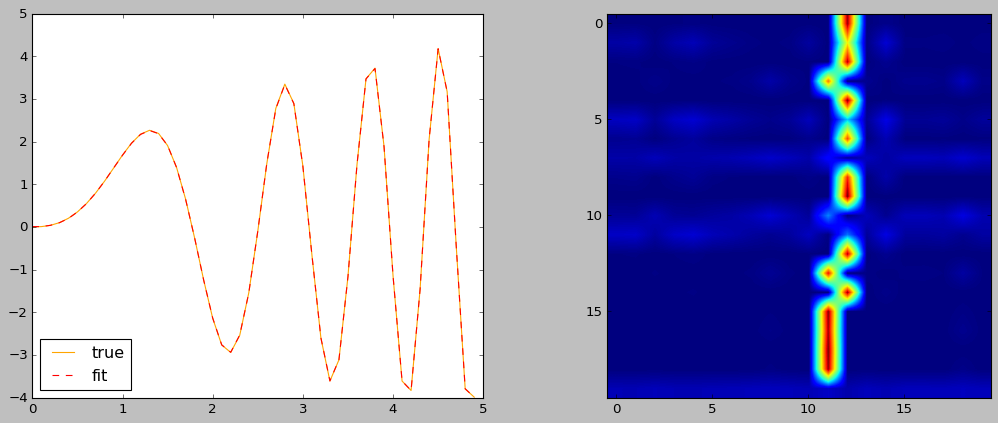

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].plot(x_val.squeeze(), y_val.squeeze(), label='true', color='orange')
axs[0].plot(x_val.squeeze(), out.detach().squeeze(), linestyle='--', label='fit', color='red')
axs[0].legend(loc='lower left')
axs[1].imshow(att_map.detach())

To fit (overfit) our data is quite easy, but how well does it "extrapolate"?

In [14]:
x_test = torch.arange(MXRANGE-0.1, 9.9, 0.1).reshape(1, -1)
y_test = f(x_test).reshape(1, -1)

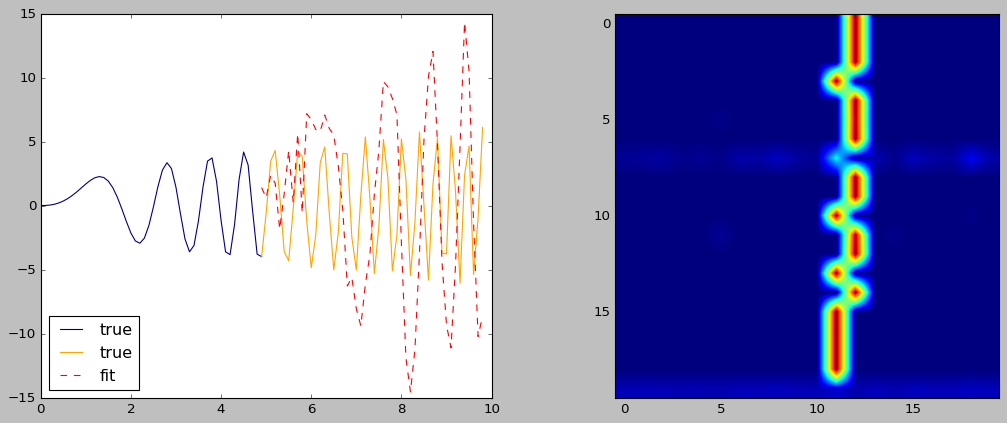

In [15]:
with torch.no_grad():
    out, att_map = att(x_test)
    
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    axs[0].plot(x_val.squeeze(), y_val.squeeze(), label='true', color='navy')
    axs[0].plot(x_test.squeeze(), y_test.squeeze(), label='true', color='orange')
    axs[0].plot(x_test.squeeze(), out.detach().squeeze(), linestyle='--', label='fit', color='red')
    axs[0].legend(loc='lower left')
    axs[1].imshow(att_map.detach())

This follows the intuition. We're trying to capture a non-linear function with linear transformations only. This proves one important point: attention mechanism is a tool that can e used in con